In [52]:
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
# import seaborn as sns

# sns.set()

In [58]:
def numerical_derivative_2d(func, epsilon):
    """
    Функция для приближённого вычисления градиента функции двух переменных. 
    :param func: np.array[2] -> float — произвольная дифференцируемая функция
    :param epsilon: float — максимальная величина приращения по осям
    :return: другая функция, которая приближённо вычисляет градиент в точке
    """
    def grad_func(x):
        """
        :param x: np.array[2] — точка, в которой нужно вычислить градиент
        :return: np.array[2] — приближённое значение градиента в этой точке
        """
        d1 = (func([x[0] + epsilon, x[1]]) - func(x)) / epsilon
        d2 = (func([x[0], x[1] + epsilon]) - func(x)) / epsilon
        return np.array(d1, d2)

    return grad_func


def grad_descent_2d(func, low, high, start=None, callback=None):
    """  
    Реализация градиентного спуска для функций двух переменных 
    с несколькими локальным минимумами, но известной квадратной окрестностью
    глобального минимума. Все тесты будут иметь такую природу.

    Обратите внимание, что здесь градиент функции не дан.
    Его нужно вычислять приближённо.

    :param func: np.ndarray -> float — функция 
    :param low: левая граница интервала по каждой из осей
    :param high: правая граница интервала по каждой из осей
    """
    eps = 1e-10
    lr = 0.5
    iters = 1000
    x = np.array([start[0], start[1]])
    df = numerical_derivative_2d(func, eps)
    callback(x, func(x))

    for i in range(iters):
        # dx1, dx2 = df(x)
        # x[0] = x[0] - dx1 * lr
        # x[1] = x[1] - dx2 * lr
        x -= df(x) * lr
        if i % 100 == 0:
            callback(x, func(x))

    return x

In [59]:
def plot_convergence_2d(func, steps, ax, xlim, ylim, cmap="viridis", title=""):
    """
    Функция отрисовки шагов градиентного спуска. 
    Не меняйте её код без необходимости! 
    :param func: функция, которая минимизируется градиентным спуском
    :param steps: np.array[N x 2] — шаги алгоритма
    :param ax: холст для отрисовки графика
    :param xlim: tuple(float), 2 — диапазон по первой оси
    :param ylim: tuple(float), 2 — диапазон по второй оси
    :param cmap: str — название палитры
    :param title: str — заголовок графика
    """

    ax.set_title(title, fontsize=20, fontweight="bold")
    # Отрисовка значений функции на фоне
    xrange = np.linspace(*xlim, 100)
    yrange = np.linspace(*ylim, 100)
    grid = np.meshgrid(xrange, yrange)
    X, Y = grid
    fvalues = func(
        np.dstack(grid).reshape(-1, 2)
    ).reshape((xrange.size, yrange.size))
    ax.pcolormesh(xrange, yrange, fvalues, cmap=cmap, alpha=0.8)
    CS = ax.contour(xrange, yrange, fvalues)
    ax.clabel(CS, CS.levels, inline=True)
    # Отрисовка шагов алгоритма в виде стрелочек
    arrow_kwargs = dict(linestyle="--", color="black", alpha=0.8)
    for i, _ in enumerate(steps):
        if i + 1 < len(steps):
            ax.arrow(
                *steps[i],
                *(steps[i+1] - steps[i]),
                **arrow_kwargs
            )
    # Отрисовка шагов алгоритма в виде точек
    n = len(steps)
    color_list = [(i / n, 0, 0, 1 - i / n) for i in range(n)]
    ax.scatter(steps[:, 0], steps[:, 1], c=color_list, zorder=10)
    ax.scatter(steps[-1, 0], steps[-1, 1], 
               color="red", label=f"estimate = {np.round(steps[-1], 2)}")
    # Финальное оформление графиков
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel("$y$")
    ax.set_xlabel("$x$")
    ax.legend(fontsize=16)

In [60]:
class LoggingCallback:
    """
    Класс для логирования шагов градиентного спуска. 
    Сохраняет точку (x, f(x)) на каждом шаге.
    Пример использования в коде: callback(x, f(x))
    """
    def __init__(self):
        self.x_steps = []
        self.y_steps = []

    def __call__(self, x, y):
        self.x_steps.append(x)
        self.y_steps.append(y)

In [61]:
def test_convergence_2d(grad_descent_2d, test_cases, tol, axes=None):
    """
    Функция для проверки корректности вашего решения в двумерном случае.
    Она же используется в тестах на Stepik, так что не меняйте её код!
    :param grad_descent_2d: ваша реализация градиентного спуска
    :param test_cases: dict(dict), тесты в формате dict с такими ключами:
        - "func" — функция 
        - "deriv" — её производная 
        - "low", "high" — диапазон для выбора начальной точки 
        - "answer" — ответ 
    При желании вы можете придумать и свои тесты.
    :param tol: предельное допустимое отклонение найденного ответа от истинного
    :param axes: матрица холстов для отрисовки, по ячейке на тест
    :return: флаг, корректно ли пройдены тесты, и дебажный вывод в случае неудачи
    """
    right_flag = True
    debug_log = []
    for i, key in enumerate(test_cases.keys()):
        # Формируем входные данные и ответ для алгоритма.
        answer = test_cases[key]["answer"]
        test_input = deepcopy(test_cases[key])
        del test_input["answer"]
        # Запускаем сам алгоритм.
        callback = LoggingCallback()  # Не забываем про логирование
        res_point = grad_descent_2d(**test_input, callback=callback)
        # Отрисовываем результаты.
        if axes is not None:
            ax = axes[np.unravel_index(i, shape=axes.shape)]
            plot_convergence_2d(
                np.vectorize(test_input["func"], signature="(n)->()"), 
                np.vstack(callback.x_steps), 
                ax=ax, 
                xlim=(test_input["low"], test_input["high"]), 
                ylim=(test_input["low"], test_input["high"]),
                title=key
            )   
        # Проверяем, что найденная точка достаточно близко к истинной
        if np.linalg.norm(answer - res_point, ord=1) > tol:
            debug_log.append(
                f"Тест '{key}':\n"
                f"\t- ответ: {answer}\n"
                f"\t- вывод алгоритма: {res_point}"
            )
            right_flag = False
    return right_flag, debug_log


C:\Users\Vadim\AppData\Local\Temp/ipykernel_11448/3691375919.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xrange, yrange, fvalues, cmap=cmap, alpha=0.8)


Не сошлось. Дебажный вывод:
Тест 'other concentric circles':
	- ответ: [0 3]
	- вывод алгоритма: [-4.27823421e-09  2.20000000e+00]
Тест 'straightened ellipses':
	- ответ: [0 3]
	- вывод алгоритма: [-0.40970505  1.79129495]


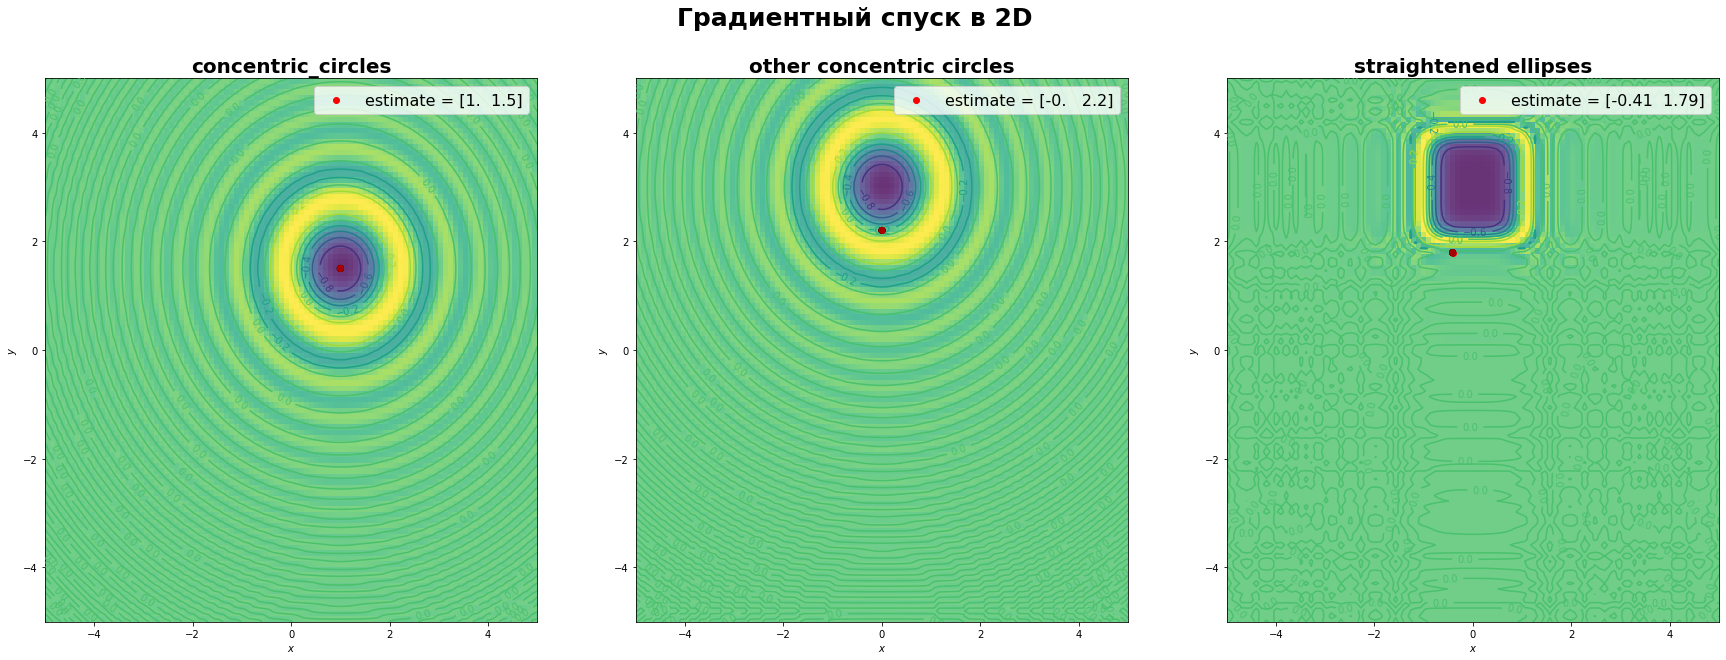

In [62]:
test_cases = {
    "concentric_circles" : {
        "func" : lambda x: (
            -1 / ((x[0] - 1)**2 + (x[1] - 1.5)**2 + 1)
            * np.cos(2 * (x[0] - 1)**2 + 2 * (x[1] - 1.5)**2)
        ),
        "low" : -5,
        "high" : 5,
        "start": np.array([.2 , .7]),
        "answer" : np.array([1, 1.5])
    },
        "other concentric circles" : {
       "func" : lambda x: (
            -1 / ((x[0])**2 + (x[1] - 3)**2 + 1)
            * np.cos(2 * (x[0])**2 + 2 * (x[1] - 3)**2)
        ),
        "low" : -5,
        "high" : 5,
        "start": np.array([1.1, 3.3]),
        "answer" : np.array([0, 3])
    },
    "straightened ellipses" : {
        "func" : lambda x: (
            -1 / ((x[0] )**4 + (x[1] - 3)**6 + 1)
            * np.cos(2 * (x[0])**4 + 2 * (x[1] - 3)**6)
        ),
        "low" : -5,
        "high" : 5,
        "start": np.array([.8, 3.001]), # точка так близко к ответу тк в окрестности ответа градиент маленкьий и функция очень плохо сходится
        "answer" : np.array([0, 3])
    },
}
tol = 1e-2  # желаемая точность

fig, axes = plt.subplots(1, 3, figsize=(30, 10), squeeze=False)
fig.suptitle("Градиентный спуск в 2D", fontsize=25, fontweight="bold")
is_correct, debug_log = test_convergence_2d(grad_descent_2d, test_cases, tol, axes)

if not is_correct:
    print("Не сошлось. Дебажный вывод:")
    for log_entry in debug_log:
        print(log_entry)